In [3]:
import re
import math 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
#To create ASCII tables
from prettytable import PrettyTable
from scipy.stats import pearsonr, chi2_contingency, kruskal,spearmanr,f_oneway
import seaborn as sns
from itertools import combinations
from scipy import stats
import statsmodels.api as sm
from collections import Counter
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')
%pylab inline


from sklearn.metrics import make_scorer,f1_score,cohen_kappa_score
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import cross_val_score,train_test_split,ShuffleSplit
from sklearn.preprocessing import LabelEncoder

def IQR(data):
    #Returns the inter-quantile range 
    return data.quantile(.75) -  data.quantile(.25)

def Is_Ok(data):
    #Returns true if feature is distributed normally else false
    rank = data.max() - data.min()
#     low = sorted([data.mean(), data.mode()[0], data.median()])[0]
#     high = sorted([data.mean(), data.mode()[0], data.median()])[2]
    diff = abs(data.median() - data.mean())
    if (abs(data.skew()) <= 1 and abs(data.kurtosis()) <= 1) and (diff < rank*0.05):
        return True
    else:
        return False
    
def pearson_corr(some_data,grade='G3'):
    #Returns Pearson correlation coefficient
    global data
    return pearsonr(some_data,data[grade])[0]

def pearson_p_value(some_data,grade='G3'):
    #Returns p-value for Pearson correlation coefficient
    global data
    return pearsonr(some_data,data[grade])[1]

def anova_test(some_data):
    #Returns ANOVA test value
    global data
    return f_oneway(*pd.crosstab(some_data.values,data['G3']).values)[0]

def anova_p_value(some_data):
    #Returns p-value for ANOVA test p-value
    global data
    return f_oneway(*pd.crosstab(some_data.values,data['G3']).values)[1]

def kruskal_test(some_data):
    #Returns Kruskal test value
    global data
    return kruskal(*pd.crosstab(some_data.values,data['G3']).values)[0]

def kruskal_p_value(some_data):
    #Returns Kruskal test p-value
    global data
    return kruskal(*pd.crosstab(some_data.values,data['G3']).values)[1]

def chi_2_test(some_data):
    #Returns chi-square test value
    global data
    return chi2_contingency(pd.crosstab(some_data.values,data['G3']),\
                            correction = False)[0]

def chi_2_p_value(some_data):
    #Returns chi-square test p-value
    global data
    return chi2_contingency(pd.crosstab(some_data.values,data['G3']),\
                            correction = False)[1]

    
def show_values_on_bars(axs):
    #Utility for showing values on bars
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
    
def rmse(predictions,targets):
    #Returns RMSE for true values and prediction
    return np.sqrt(((predictions - targets) ** 2).mean())
    
rmse_scorer = make_scorer(rmse)

Populating the interactive namespace from numpy and matplotlib


# Introduction

Every company wants it’s processes to be as effective as possible. To address this issue, a lot of techniques were invented and one of them is a Six Sigma – a set of techniques and tools for process improvement. This method improves the quality of output of a process by identifying and removing the causes of defects and minimizing the variability in a technological, manufacturing or business process.

Six Sigma approach has proven to be succesfull in many cases, being applied for large and relatively small companies. There are stories of Six Sigma success written by such companies as Motorola, General Electric, Federal Express and so on. Used wisely, this approach could solve a lot of different optimization problems. Detailed example of one of such stories is the article written by Anne Cesarone for the portal goleansixsigma.com, where she explains how she reduced router configuration time by 55%

But, as we all know, there is no such thing as free lunch and sometimes even good methodologies could fail our expectations. The 3M company applied Six Sigma's strict process and it's lack of freedom caused significant roadblocks and killed innovation in 3M. As it was an technological innovative company such an outcome led to drop of new products revenue from 33% of total revenue down to roughly 20%. Former 3M vice president Geoff Nicholson said that the Six Sigma should not be applied to creative stages, since it was designed for manufacturing when starting to scale up a product.

The purpose of this work is to demonstrate an example of how the data analysis could be performed to get useful insights from the data provided and use them to improve some of the underlying processes using the Six Sigma metrics and general approach of reducing the process variability.

# Methodology

The data for this work came from Kaggle and contains info about student achievement in mathematics in secondary education of two Portuguese schools. Dataset contains both numerical and categorical features. In this dataset final grade (‘G3’) and weekday alcohol consumption (‘Walc’) were chosen as the subjects to modeling and further optimization. Next subsection will describe the statistical methods used to analyze the data:


In the analysis of numerical attributes, we used more basic dimensions such as: maximum or minimum value, range from minimum to maximum value, average, median and most common value - mode. In addition to the simple and very commonly used ones, we also used some measures, such as kurtosis, skewness, standard deviation, and interquartile spacing (IQR). With the help of these, in combination with the above, we can more precisely determine whether or not the value of a variable is a normal distribution. [[1](#Literature)]

This work involves use of statistical tests, both for categorical and numerical features and their combinations. Statistical tests are used to test some hypotheses. Usual approach is to form so-called null hypothesis  and an alternative (one- or two-sided). After that we compute the desired statistics and it's p-value. P-value or probability value is the probability of obtaining test results at least as extreme as the results actually observed during the test, assuming that the null hypothesis is correct.[[2](#Literature)]

## Metrics

### Standard deviation

The standard deviation is a measure of dispersion calculated as the square root of the variance. The variance describes the distance of the value of the variable to the arithmetic mean.[[1](#Literature)]

![title](img/02.png)

### Interquartile spacing

Interquartile spacing describes the range of values of a variable if we cut off the lower and upper 25% of the value. It is therefore the distance between the first and third quartiles. [[1](#Literature)]

![title](img/Screenshot_03.png)

## Statistical tests

### How to interpret p_value 

For all the tests below we calculate p-value for the obtained statistics and reject null hypothesis in case of p-value is less than 0.05.[[2](#Literature)]

### Pearson’s correlation test 

Pearson product-moment correlation coefficient (PPMCC) or the bivariate correlation, is a measure of the linear correlation between two variables X and Y. According to the Cauchy–Schwarz inequality it has a value between +1 and −1, where 1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation. The important thing about this test is that it assumes the normal distribution of two features.[[3](#Literature)]

### Spearman’s correlation test

The Spearman's rank-order correlation is the nonparametric version of the Pearson product-moment correlation. Spearman's correlation coefficient measures the strength and direction of association between two ranked variables.[[3](#Literature)]

### Chi-square test

The phrase "a chi-square test" could be used as the description of any statistical hypothesis test where the sampling distribution of the test statistic is, under some circumstances, approximately, or is simply hoped to be approximately, a chi-squared distribution, when the null hypothesis is true. Usually however, the phrase is used as short for Pearson's chi-squared test, and variants thereof. Pearson's chi-squared test is used to determine whether there is a statistically significant difference (i.e., a difference which clearly is not just due to chance fluctuations) between the expected frequencies and the observed frequencies in one or more categories of a so-called contingency table.[[3](#Literature)]

### ANOVA test

Analysis of variance (ANOVA) is a collection of statistical models and their associated estimation procedures (such as the "variation" among and between groups) used to analyze the differences among group means in a sample. ANOVA was developed by statistician and evolutionary biologist Ronald Fisher. The ANOVA is based on the law of total variance, where the observed variance in a particular variable is partitioned into components attributable to different sources of variation. In its simplest form, ANOVA provides a statistical test of whether two or more population means are equal, and therefore generalizes the t-test beyond two means.[[3](#Literature)]

### Kruskal–Wallis one-way analysis of variance


The Kruskal–Wallis test by ranks, Kruskal–Wallis H test (named after William Kruskal and W. Allen Wallis), or one-way ANOVA on ranks is a non-parametric method for testing whether samples originate from the same distribution. It is used for comparing two or more independent samples of equal or different sample sizes. It extends the Mann–Whitney U test, which is used for comparing only two groups. The parametric equivalent of the Kruskal–Wallis test is the one-way analysis of variance (ANOVA).[[3](#Literature)]

## Modeling


In this work two kinds of predictive models were used to get the understanding of underlying process and to make assumptions on effects of different optimization schemes on it.


### Linear Regression


Linear regression is a procedure in which we search for a linear combination of variables xi for the output variable y. The general formula can be written as:
y=β0+β1x1+⋯+βkxk.
The coefficients βi for the input attributes are chosen in such a way as to minimize the prediction error.[[4](#Literature)]

### LogisticRegression

Logistic regression is a statistical method for analyzing a multitude of data with one or more independent variables that determine categorical output. The logistic regression predictive model operates on the principle of a sigmoid function, which determines the optimal threshold in a way that maximizes the number of correct predictions with respect to input attributes. The threshold can be easily determined using the confusion matrix, contingency tables.[[5](#Literature)]

We know binary logistic regression, logistic regression with two possible outputs, logistic regression for three or more nominal categorical outputs, and logistic regression for three or more ordinal categorical outputs.[[5](#Literature)]

### Random Forest


Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set. Unlike the linear regression, random forest can detect non-linear interactions between predictors.[[6](#Literature)]

## Evaluating models performance

To analyze the models performance and to be able to compare them we use evaluation metrics, which show us how good or how bad we are in predicting the target variable. Depending on the task given we could use different metrics.

### RMSE, used for regression tasks

<img src="img/rmse.png" alt="Drawing" style="width: 200px;"/>

### F1 score

In statistical analysis of binary classification, the F1 score (also F-score or F-measure) is a measure of a test's accuracy. It considers both the precision p and the recall r of the test to compute the score: p is the number of correct positive results divided by the number of all positive results returned by the classifier, and r is the number of correct positive results divided by the number of all relevant samples (all samples that should have been identified as positive). The F1 score is the harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.[[7](#Literature)]

Here, 'TP' stands for 'True positive', 'FN' stands for 'False negative' and FP stands for 'False positive', 

![title](img/f1.png)

## Optimization results analysis


### Cohen's kappa coefficient


The kappa statistic is often used to evaluate the match between two estimators evaluating the same binary measurement. The coefficient measures the percentage of units in which estimates match according to the expected coincidence resulting from chance. The contingency table is used to calculate the coefficient. Depending on the value of the coefficient, the match may be weak (K<0,2), partial (0,2≤K<0,4), medium strong (0,4≤K<0,8), strong (0,6≤K<0,8) or very strong (0,8≤K<1)[[8](#Literature)]


### Bland-Altman plot


Bland-Altman plots are extensively used to evaluate the agreement among two different instruments or two measurements techniques. Bland-Altman plots allow identification of any systematic difference between the measurements (i.e., fixed bias) or possible outliers. The mean difference is the estimated bias, and the SD of the differences measures the random fluctuations around this mean. If the mean value of the difference differs significantly from 0 on the basis of a 1-sample t-test, this indicates the presence of fixed bias. If there is a consistent bias, it can be adjusted for by subtracting the mean difference from the new method. It is common to compute 95% limits of agreement for each comparison (average difference ± 1.96 standard deviation of the difference), which tells us how far apart measurements by 2 methods were more likely to be for most individuals. If the differences within mean ± 1.96 SD are not clinically important, the two methods may be used interchangeably. The 95% limits of agreement can be unreliable estimates of the population parameters especially for small sample sizes so, when comparing methods or assessing repeatability, it is important to calculate confidence intervals for 95% limits of agreement. This can be done by Bland and Altman's approximate method or by more precise methods.[[9](#Literature)]

The t-test is any statistical hypothesis test in which the test statistic follows a Student's t-distribution under the null hypothesis.

A t-test is most commonly applied when the test statistic would follow a normal distribution if the value of a scaling term in the test statistic were known. When the scaling term is unknown and is replaced by an estimate based on the data, the test statistics (under certain conditions) follow a Student's t distribution. The t-test can be used, for example, to determine if the means of two sets of data are significantly different from each other. [3]

In [4]:
data = pd.read_csv('data/student-mat.csv')
numerics = ['int16','int32','int64','float16','float32','float64']
dfNum = data.select_dtypes(include=numerics)
dfDis = data.select_dtypes(exclude=numerics)

In [5]:
print('NaN values:')
data.isna().sum()

NaN values:


school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

# Exploratory data analysis

Let's begin the analysis of the data given. In this dataset there are no missing values so nothing special to fix before performing an analysis

This dataset has 33 columns in it and 395 entries. Below is the list of all attributes:

In [6]:
print('List of attributes: ' + ', '.join(x for x in data.columns))

List of attributes: school, sex, age, address, famsize, Pstatus, Medu, Fedu, Mjob, Fjob, reason, guardian, traveltime, studytime, failures, schoolsup, famsup, paid, activities, nursery, higher, internet, romantic, famrel, freetime, goout, Dalc, Walc, health, absences, G1, G2, G3


## Numerical features analysis

As we see from histograms with numerical features distribution - there a not so many features which are distributed normally. Sometimes you could read that it should stop us from using linear regression, but it is a common misconception, since it assumes the normality of residuals distribution and not of the actual data. Also, we could see that most of numerical features are ordinal and take values in range from 1 to 5 and only few are continious such as G1-G3 and age.

Text(0.5, 0.98, 'Numerical features distribution')

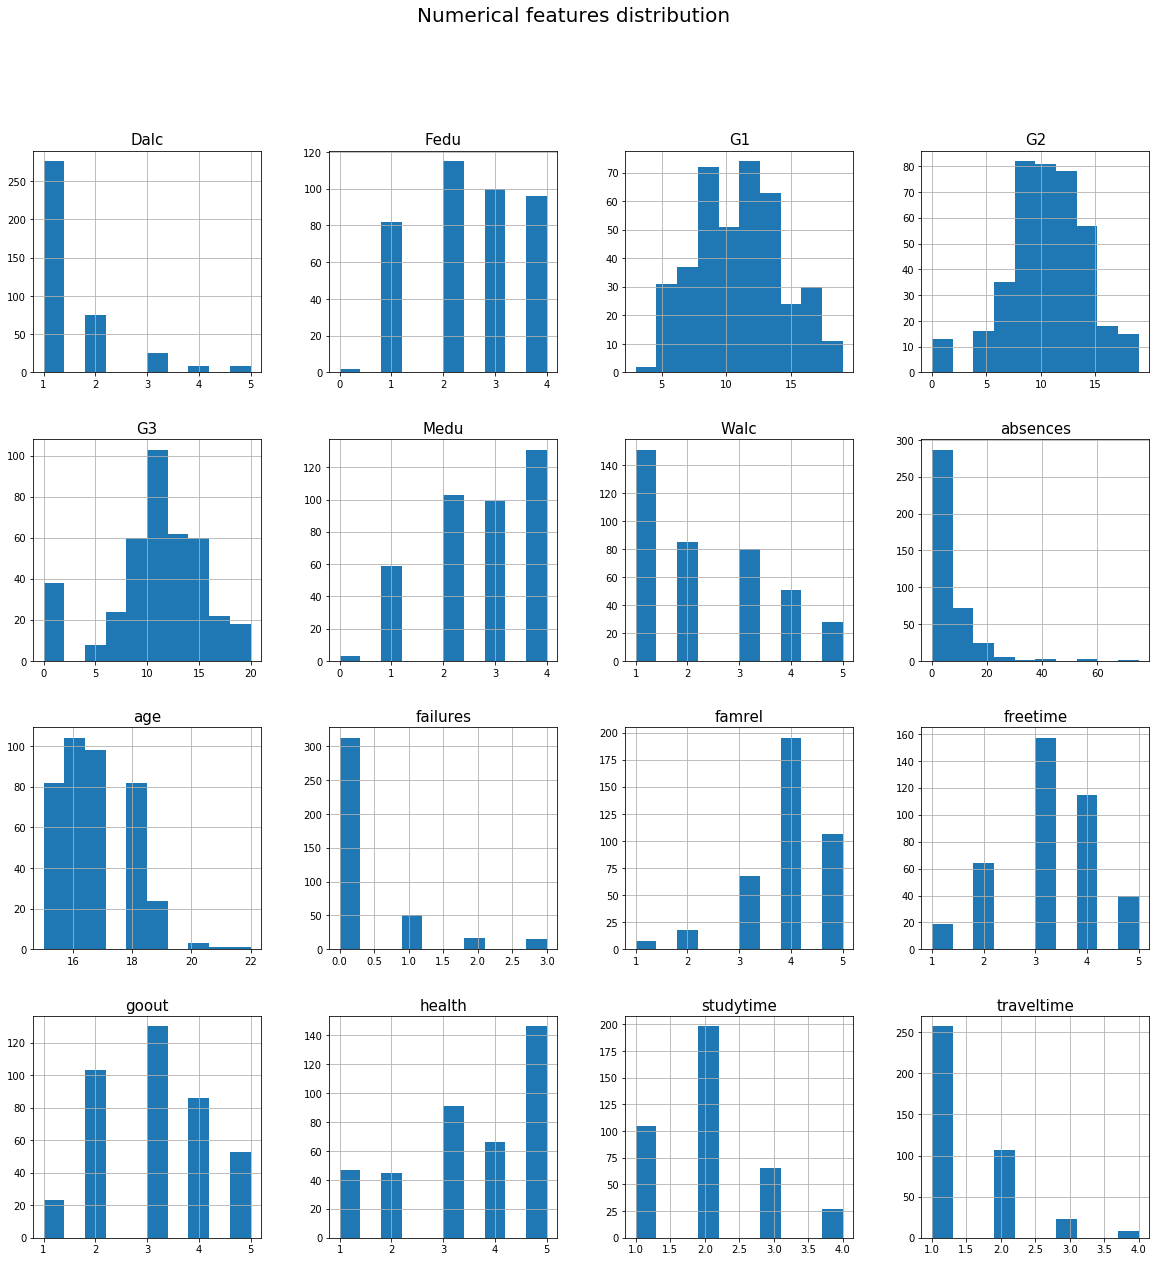

In [7]:
fig = dfNum.hist(figsize=(20,20));
[x.title.set_size(15) for x in fig.ravel()];
plt.suptitle('Numerical features distribution',fontsize=20)

Here we are getting some information about our numerical features and use the “Over the thumb” rule to determine whether the feature is distributed normally or not.

In [8]:
num_stats = dfNum.transpose().agg(['mean','median','std',IQR,'min','max','skew','kurtosis',Is_Ok],axis=1)
num_stats['rank'] = num_stats.apply(lambda x: x['max'] - x['min'],axis=1)
num_stats['mode'] = dfNum.transpose().mode(axis=1)
num_stats.columns = [x if x != 'Is_Ok' else 'Is_Normal' for x in num_stats.columns ]
num_stats

,mean,median,std,IQR,min,max,skew,kurtosis,Is_Normal,rank,mode
age,16.6962,17,1.27604,2,15,22,0.46627,-0.00122178,True,7,16
Medu,2.74937,3,1.09474,2,0,4,-0.318381,-1.09001,False,4,4
Fedu,2.52152,2,1.0882,1,0,4,-0.0316721,-1.19854,False,4,2
traveltime,1.4481,1,0.697505,1,1,4,1.60703,2.34419,False,3,1
studytime,2.03544,2,0.83924,1,1,4,0.632142,-0.0144318,True,3,2
failures,0.334177,0,0.743651,0,0,3,2.38703,5.00473,False,3,0
famrel,3.9443,4,0.896659,1,1,5,-0.951882,1.13977,False,4,4
freetime,3.23544,3,0.998862,1,1,5,-0.163351,-0.301807,False,4,3
goout,3.10886,3,1.11328,2,1,5,0.116502,-0.77025,True,4,3
Dalc,1.48101,1,0.890741,1,1,5,2.19076,4.75949,False,4,1


We could divide all numerical features to four different categories and for each of them different statistical test will be applied in order to find correlation with target variable. For normally distributed conitinious features we will use Pearson correlation, for skewed conitinious features we will use Spearman correlation, for normally distributed ordinal features we will use ANOVA and for skewed ordinal features we will use Kruskal-Wallis test.

In [9]:
#Select numerical features with small discrete range of values
ordinal = data.columns[np.where(data.nunique() < 6)]
#Select all other numerical features
continious = data.columns[np.where(data.nunique() >= 6)]
#For each of numerical features we ca,culated if they distributed normally or not. Now, we will divide them in
#four subgroups - normal-ordinal, normal-continious, skewed-ordinal, skewed-continious
norm_ord = num_stats[(num_stats.index.isin(ordinal)) & (num_stats.Is_Normal == True)].index
norm_cont = num_stats[(num_stats.index.isin(continious)) & (num_stats.Is_Normal == True)].index
skew_ord = num_stats[(num_stats.index.isin(ordinal)) & (num_stats.Is_Normal == False)].index
skew_cont = num_stats[(num_stats.index.isin(continious)) & (num_stats.Is_Normal == False)].index
print('Number of normal ordinal features: %d' % (len(norm_ord)) +\
      '. List of these features: ' + ', '.join(norm_ord))
print('Number of normal continious features: %d' % (len(norm_cont)) +\
      '. List of these features: ' + ', '.join(norm_cont))
print('Number of skewed ordinal features: %d' % (len(skew_ord)) +\
      '. List of these features: ' + ', '.join(skew_ord))
print('Number of skewed continious features: %d' % (len(skew_cont)) +\
      '. List of these features: ' + ', '.join(skew_cont))


Number of normal ordinal features: 2. List of these features: studytime, goout
Number of normal continious features: 4. List of these features: age, G1, G2, G3
Number of skewed ordinal features: 9. List of these features: Medu, Fedu, traveltime, failures, famrel, freetime, Dalc, Walc, health
Number of skewed continious features: 1. List of these features: absences


### Pearson correlation coefficient for normally distributed features

Here we can see, that all the grades are correlated positively with target feature and 'age' feature is correlated negativelty. This means, that if we increase, for example, 'G1', 'G3' will also increase and if we increase 'age', 'G3' will decrease.

In [10]:
norm_cont_info = data[norm_cont].drop('G3',1).agg([pearson_corr,pearson_p_value]).transpose()
norm_cont_info['significant'] = norm_cont_info.apply(lambda x: 'Yes' if x['pearson_p_value'] < 0.05 else 'No',axis=1)
print('Significant features:')
norm_cont_info[norm_cont_info.significant == 'Yes'].sort_values('pearson_corr',ascending=False)

Significant features:


,pearson_corr,pearson_p_value,significant
G2,0.904868,7.625719e-148,Yes
G1,0.801468,9.001430e-90,Yes
age,-0.161579,1.271439e-03,Yes


### Let's compute ANOVA for the normally distributed ordinal features

As we have groups of students formed by some ordinal feature we want to know if the mean final grade significantly different for this groups or not. For this we will use the ANOVA test. Null hypothesis - there is no difference in means between groups. Alternative - such difference actually takes place.

In [11]:
norm_ord_info = data[norm_ord].agg([anova_test,anova_p_value]).transpose()
norm_ord_info['significant'] = norm_ord_info.apply(lambda x: 'Yes' if x['anova_p_value'] < 0.05 else 'No',axis=1)
print('Significant features:')
norm_ord_info[norm_ord_info.significant == 'Yes'].sort_values('anova_test',ascending=False)

Significant features:


,anova_test,anova_p_value,significant
studytime,10.680522,0.000008,Yes
goout,6.098662,0.000231,Yes


### Performing Spearman test on skewed continious features.

As it was said above, the Spearman correlation coefficient is used when the features are not distributed normally. Again, we will fill the table only with those features, that are significantly correlated with the final grade. As we can see, non of skewed features is correlated significantly with final grade.

In [12]:
cont_skew_info = data[skew_cont].apply([lambda x: spearmanr(x,data['G3'])[0],lambda x: spearmanr(x,data['G3'])[1]]).transpose()
cont_skew_info.columns = ['corr_coeff','p_val']
cont_skew_info['significant'] = cont_skew_info.apply(lambda x: 'Yes' if x['p_val'] < 0.05 else 'No',axis=1)
print('Significant features:')
cont_skew_info[cont_skew_info.significant == 'Yes'].sort_values('corr_coeff',ascending=False)

Significant features:


,corr_coeff,p_val,significant


### Performing Kruskal-Wallis for skewed ordinal features

Since Kruskal-Wallis test is a non-parametric version of ANOVA we could use it  for the same purposes for skewed ordinal features. Again, null hypothesis is that there is no difference in means of different groups, alternative that the such difference actually takes place. As we could see from the table below, looking at the obtained statistics values, the most significant feature is daily alcohol consumption.

In [13]:
ord_skew_info = data[skew_ord].agg([kruskal_test,kruskal_p_value]).transpose()
ord_skew_info['significant'] = ord_skew_info.apply(lambda x: 'Yes' if x['kruskal_p_value'] < 0.05 else 'No',axis=1)
print('Significant features:')
ord_skew_info[ord_skew_info.significant == 'Yes'].sort_values('kruskal_test',ascending=False)

Significant features:


,kruskal_test,kruskal_p_value,significant
Dalc,46.773550,1.699836e-09,Yes
famrel,42.222035,1.500411e-08,Yes
traveltime,41.234674,5.831082e-09,Yes
Medu,35.790653,3.195308e-07,Yes
Fedu,31.655825,2.249340e-06,Yes
failures,31.350712,7.171116e-07,Yes
freetime,26.559883,2.439614e-05,Yes
Walc,18.306724,1.074869e-03,Yes
health,11.642657,2.021613e-02,Yes


## Categorical features

In [12]:
print("Categories percentage for categorical features:")
for col in dfDis.columns:
    print((dfDis.groupby(col)[col].count() / dfDis.shape[0] * 100).to_string())

Categories percentage for categorical features:
school
GP    88.35443
MS    11.64557
sex
F    52.658228
M    47.341772
address
R    22.278481
U    77.721519
famsize
GT3    71.139241
LE3    28.860759
Pstatus
A    10.379747
T    89.620253
Mjob
at_home     14.936709
health       8.607595
other       35.696203
services    26.075949
teacher     14.683544
Fjob
at_home      5.063291
health       4.556962
other       54.936709
services    28.101266
teacher      7.341772
reason
course        36.708861
home          27.594937
other          9.113924
reputation    26.582278
guardian
father    22.784810
mother    69.113924
other      8.101266
schoolsup
no     87.088608
yes    12.911392
famsup
no     38.734177
yes    61.265823
paid
no     54.177215
yes    45.822785
activities
no     49.113924
yes    50.886076
nursery
no     20.506329
yes    79.493671
higher
no      5.063291
yes    94.936709
internet
no     16.708861
yes    83.291139
romantic
no     66.582278
yes    33.417722


In [13]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() - 4
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In the histograms below it is clear that the classes in almost every categorical features are pretty unbalanced. The only exceptions are the 'activities' and, more or less, 'sex' features. In other cases we could see strong imbalance in classes distribution.

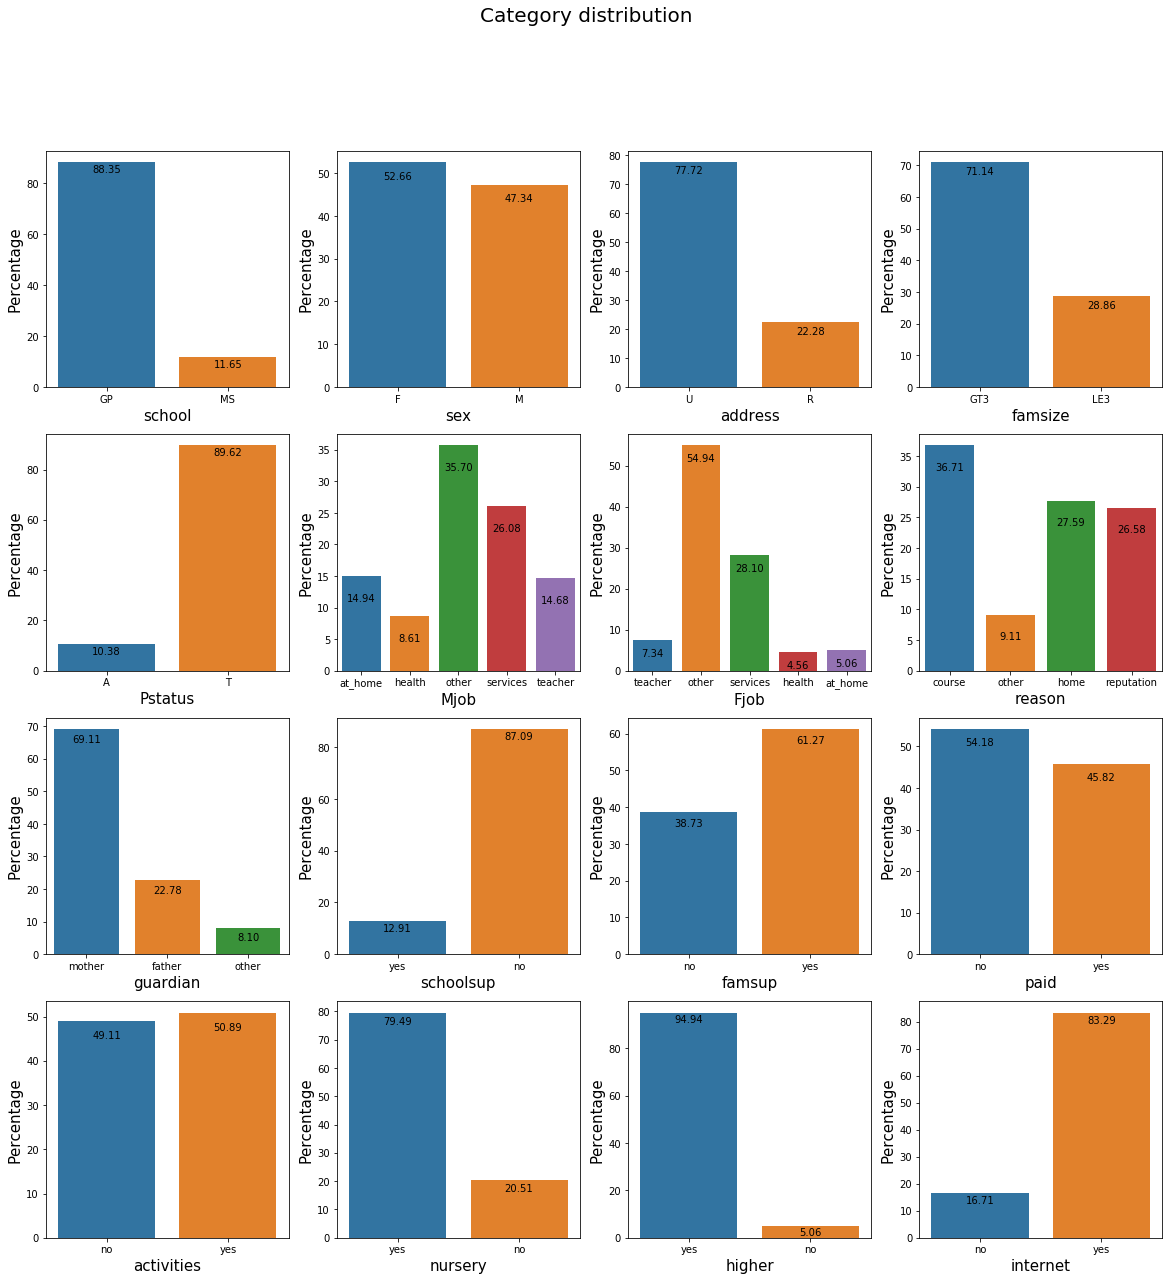

In [14]:
fig,ax = plt.subplots(4,4,figsize=(20,20))
fig.suptitle('Category distribution',fontsize=20)
for ind,col in enumerate(dfDis.columns[:16]):
    sns.barplot(x = col, y = 'age', data = data, ax = ax.flatten()[ind],estimator=lambda x: len(x) / len(dfDis) * 100)
    
[x.set_xlabel(dfDis.columns[ind],fontsize = 15) for ind,x in enumerate(ax.flatten())];
[x.set_ylabel('Percentage',fontsize = 15) for x in ax.flatten()];

for ax_ in ax.ravel():
    show_values_on_bars(ax_)

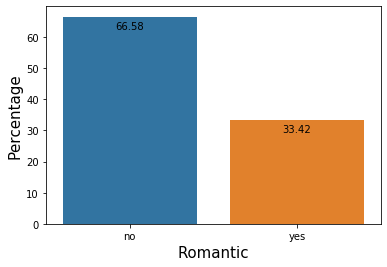

In [15]:
ax = sns.barplot(x = dfDis.columns[-1], y = 'age', data = data,estimator=lambda x: len(x) / len(dfDis) * 100)
ax.set_ylabel('Percentage',fontsize=15)
ax.set_xlabel('Romantic',fontsize=15)

show_values_on_bars(ax)

### Boxplots for categorical features

Below are boxplot diagrams for the categorical feature. Boxplot is a method for graphically depicting groups of numerical data through their quartiles. The box borders are 25th and 75th percentile, line in the box is the median value, outer borders are minimum and maximum (Q1 - 1.5*IQR, Q3 + 1.5*IQR) and points outside them are outliers. Boxplot could help us to gain quick insights about the data in the form which is easy-to-read. For example, if the look at 'Mjob' feature we will instantly see that the final grade median value is different between groups of students with different 'Mjob' value. Still, we could not rely on the visuals so we will use statistical tests designed to be applied for the categorical features to make further conclusions about different groups and their difference.

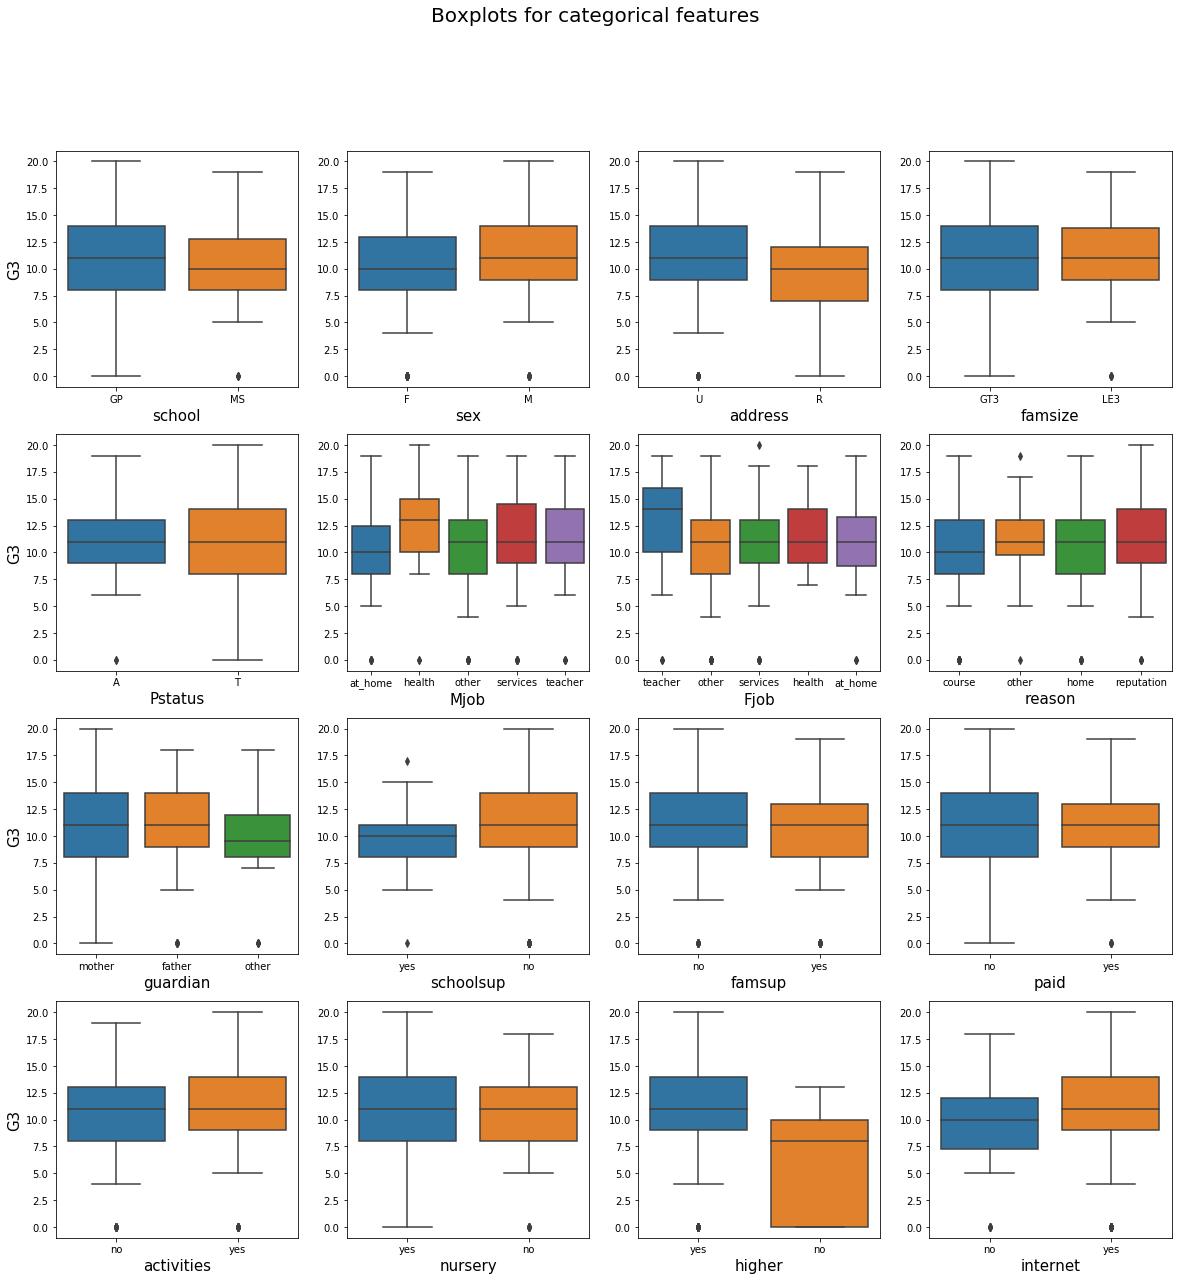

In [16]:
fig,ax = plt.subplots(4,4,figsize=(20,20))
fig.suptitle('Boxplots for categorical features',fontsize=20)
for ind,col in enumerate(dfDis.columns[:16]):
    sns.boxplot(x = col, y = 'G3', data = data, ax = ax.flatten()[ind])
    
[x.set_xlabel(dfDis.columns[ind],fontsize = 15) for ind,x in enumerate(ax.flatten())];
[x.set_ylabel('G3',fontsize = 15) if ind%4 == 0 else x.set_ylabel('',fontsize = 15) for ind,x in enumerate(ax.flatten())];

for ax_ in ax.ravel():
    show_values_on_bars(ax_)

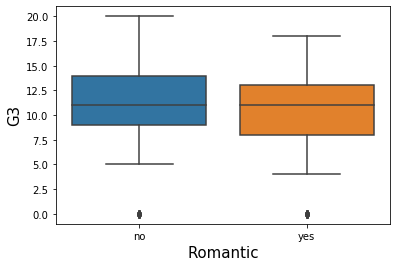

In [17]:
ax = sns.boxplot(x = dfDis.columns[-1], y = 'G3', data = data)
ax.set_ylabel('G3',fontsize=15)
ax.set_xlabel('Romantic',fontsize=15)

show_values_on_bars(ax)

### For the categorical features we will aplly a simple scheme. First, we will encode all the features to the binary space and then we will use chi-square test to identify features, for which mean grade in groups will be significantly different.

In [14]:
dfDis = pd.get_dummies(dfDis)

In [15]:
cat_info = dfDis.agg([chi_2_test,chi_2_p_value]).transpose()
cat_info['significant'] = cat_info['chi_2_p_value'].apply(lambda x: 'Yes' if x < .05 else 'No')
cat_info.columns = ['chi2','p_val','significant']
print('Significant features:')
cat_info[cat_info.significant == 'Yes'].sort_values('chi2',ascending=False)

Significant features:


,chi2,p_val,significant
schoolsup_yes,32.517477,0.012967,Yes
schoolsup_no,32.517477,0.012967,Yes
romantic_yes,30.172482,0.025128,Yes
romantic_no,30.172482,0.025128,Yes
paid_yes,29.772479,0.028033,Yes
paid_no,29.772479,0.028033,Yes
Mjob_services,29.204075,0.032690,Yes


# Modeling and optimization

After the exploratory data analysis stage it is time for modeling. Modeling is crucial for optimization tasks since it is safer, cheaper and in a lot of situations faster to check out different approaches to the problem by changing the input data and looking to the output of the model. Hence, if we will succeed in building the predictive model and it will produce reliable results we could use this model for solving our problem.

There is a common scheme for building such models. First, we split our data to  train and validation sets in proportion 9:1. Train set will be used for building model and hyperparameter tuning and validation set is used on the final stage to get unbiased metric of our model. For the train data we will use cross-validation scheme, which shrinks training data to even chunks and perform train-prediction procedure multiple times so that our performance metric value is less biased.[[4](#Literature)]

In machine learning, hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm. A hyperparameter is a parameter whose value is used to control the learning process. By contrast, the values of other parameters (typically node weights) are learned.[[4](#Literature)]

## Optimization example 1. Final grade prediction. Baseline prediction - median grade in train data

For final grade prediction we will use all the data given except the 'G2' and 'G1' features since it is is more difficult to predict G3 without G2 and G1, but such prediction is much more useful.

First, let's set up a baseline for our model. For example, what value will RMSE metric take if we will always predict the median value of the final grade?

In [35]:
whole_data = pd.concat([dfNum,dfDis],axis=1).drop(['G2','G1'],axis=1)
train,test = train_test_split(whole_data,random_state=42,test_size = .1,shuffle=True)
baseline = rmse([train['G3'].median() for i in range(train.shape[0])],train['G3'])
print('Baseline for final grade prediction: %.4f' % baseline)

Baseline for final grade prediction: 4.5669


First, let's model the desired process - in this case the student's performance. First, we will try Linear Regression with all the features

In [36]:
whole_data = pd.concat([dfNum,dfDis],axis=1).drop(['G2','G1'],axis=1)
train,test = train_test_split(whole_data,random_state=42,test_size = .1,shuffle=True)
X_train,y_train, X_test, y_test = train.drop('G3',axis=1),train['G3'],test.drop('G3',axis=1),test['G3']
lr = LinearRegression()
print('Simple Linear Regression with all the features with RMSE as a metric.')
print('Linear Regression, all features score: %.4f' % (cross_val_score(lr,X_train,y_train,scoring=rmse_scorer,cv=ShuffleSplit(n_splits=5,random_state=42)).mean()))

Simple Linear Regression with all the features with RMSE as a metric.
Linear Regression, all features score: 4.1791


Result is better than the baseline so our model is working. But could we do better? For example, let's leave only those features, that are significantly correlate with the target feature.

In [37]:
good_features = np.hstack([norm_ord_info[norm_ord_info.significant == 'Yes'].index,\
                            norm_cont_info[norm_cont_info.significant == 'Yes'].index,\
                            cont_skew_info[cont_skew_info.significant == 'Yes'].index,\
                            ord_skew_info[ord_skew_info.significant == 'Yes'].index,\
                            cat_info[cat_info.significant == 'Yes'].index,['G3']])
whole_data = pd.concat([dfNum,dfDis],axis=1)[good_features].drop(['G2','G1'],axis=1)
train,test = train_test_split(whole_data,random_state=42,test_size = .1,shuffle=True)
X_train,y_train, X_test, y_test = train.drop('G3',axis=1),train['G3'],test.drop('G3',axis=1),test['G3']
lr = LinearRegression()
print("Let's leave only the significant features with linear correlation with target variable")
#cross_val_score(estimator, data to fit, variable for prediction, estimator, cv-determines 
#the cross-validation splitting strategy)

print('Linear Regression trained on significant features: %.4f' % abs(cross_val_score(lr,X_train,y_train,scoring=rmse_scorer,cv=ShuffleSplit(n_splits=5,random_state=42)).mean()))

Let's leave only the significant features with linear correlation with target variable
Linear Regression trained on significant features: 4.1841


As the total score after excluding not correlated features has gotten worse we could make aconclusion that there could be non-linear interactions between variables which we couldn'tfind with statistical tests. Other availible option is to apply log-transform for the skewed features since it is sometimes increase the linear models performance. Let's apply this transformation to the 'age' and 'absences' features.

In [38]:
whole_data = pd.concat([dfNum,dfDis],axis=1).drop(['G2','G1'],axis=1)
whole_data[['age','absences']] = whole_data[['age','absences']].apply(lambda x: np.log1p(x))#log(1+x)
train,test = train_test_split(whole_data,random_state=42,test_size = .1,shuffle=True)
X_train,y_train, X_test, y_test = train.drop('G3',axis=1),train['G3'],test.drop('G3',axis=1),test['G3']
lr = LinearRegression()
print('Linear Regression trained on all features with additional log-transform: %.4f' % abs(cross_val_score(lr,X_train,y_train,scoring=rmse_scorer,cv=ShuffleSplit(n_splits=5,random_state=42)).mean()))

Linear Regression trained on all features with additional log-transform: 4.0997


Finally, let's try non-linear model. Since we found that there could be non-linear interactions between variables we could benefit from using non-linear model such as Random Forest.

In [39]:
rf = RandomForestClassifier(random_state = 42)
whole_data = pd.concat([dfNum,dfDis],axis=1).drop(['G2','G1'],axis=1)
whole_data[['age','absences']] = whole_data[['age','absences']].apply(lambda x: np.log1p(x))
train,test = train_test_split(whole_data,random_state=42,test_size = .1,shuffle=True)
X_train,y_train, X_test, y_test = train.drop('G3',axis=1),train['G3'],test.drop('G3',axis=1),test['G3']
print('Random Forest trained on all features with additional log-transform: %.4f' % abs(cross_val_score(rf,X_train,y_train,scoring=rmse_scorer,cv=ShuffleSplit(n_splits=5,random_state=42)).mean()))

Random Forest trained on all features with additional log-transform: 5.4808


As we could see, the Linear Regression outperformed Random Forest. Let's do the final check and get the RMSE on the validation set.

In [40]:
print('Linear Regression RMSE on validation set: %.4f' % rmse(y_test,list(map(int,lr.fit(X_train,y_train).predict(X_test)))))
print('Random Forest RMSE on validation set: %.4f' % rmse(y_test,list(map(int,rf.fit(X_train,y_train).predict(X_test)))))

Linear Regression RMSE on validation set: 4.6957
Random Forest RMSE on validation set: 6.7063


Turns out, the Linear Regression is our best choice.

### Optimization, analysis of the results

In [41]:
print('Significantly correlated features: ' + ', '.join(good_features))

Significantly correlated features: studytime, goout, age, G1, G2, Medu, Fedu, traveltime, failures, famrel, freetime, Dalc, Walc, health, Mjob_services, schoolsup_no, schoolsup_yes, paid_no, paid_yes, romantic_no, romantic_yes, G3


Using the obtained knowledge we changed the input data to optimize the desired process. We then used the model to predict how the changes will affect the outcome. In order to increase number of students with excellent final grade we decreased their alcohol consumption and talked to their parents to underline the necessity of making the study their kids first priority instead of having a lot of free time. But the most impressive results were obtained by lowering the age of students by one which may be explained by the fact, that ability to learn is decreasing with age.

In [76]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() - 20
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [79]:
updated_data = whole_data.copy(deep=True).drop('G3',1)
updated_data['Walc'] = updated_data['Walc'].apply(lambda x: math.ceil(x * .8))
updated_data['Dalc'] = updated_data['Dalc'].apply(lambda x: math.ceil(x * .4))
updated_data['freetime'] = updated_data['freetime'].apply(lambda x: math.ceil(x * .7))
#updated_data['age'] = updated_data['age'] - 1

Excellent students percentage before optimization: 6.0759
Excellent students percentage after optimization: 0.5063
Cohen-Kappa score: 0.0564


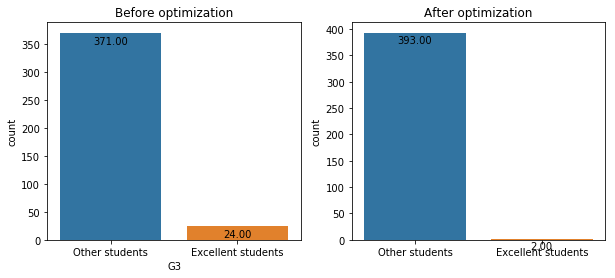

In [80]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
sns.countplot((data.G3 > 16).replace({True:'Excellent students',False:'Other students'}),ax=ax[0])
ax[0].set_title('Before optimization')
sns.countplot(['Excellent students' if x == True else 'Other students' for x in (lr.predict(updated_data) > 16)],ax = ax[1])
ax[1].set_title('After optimization')
for ax_ in ax.flatten():
    show_values_on_bars(ax_)
    
print('Excellent students percentage before optimization: %.4f' % (sum(data.G3 > 16) / data.shape[0] * 100))
print('Excellent students percentage after optimization: %.4f' % (sum(lr.predict(updated_data) > 16) / data.shape[0] * 100))
# print('Cohen-Kappa score: %.4f' % (cohen_kappa_score(data.G3,lr.predict(updated_data))))
print('Cohen-Kappa score: %.4f' % (cohen_kappa_score(data.G3,(lr.predict(updated_data)).astype('int32'))))

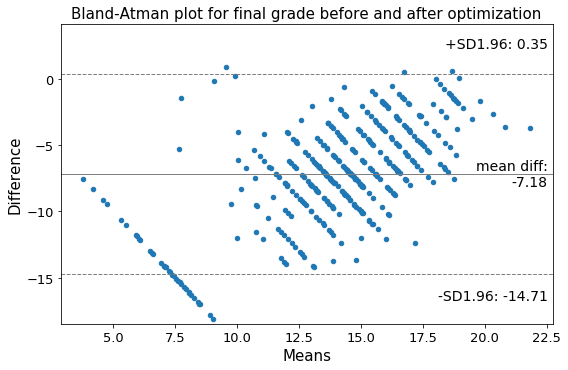

In [30]:
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(data.G3, lr.predict(updated_data),ax=ax)
ax.set_title('Bland-Atman plot for final grade before and after optimization',fontsize=15)
plt.show()

Bland Atman plot and Cohen-Cappa score are used in this work in order to make sure, that changes in the process are relevant and trustworthy. The lower Cohen-Cappa score - the better for our purposes. Cohen-Cappa score and the look of Bland-Atman plot confirm that our optimization results are relevant and trustworthy.


We use DPMO in this work as the success metric for the optimization task. DPNO stands for Defects-Per-Million-Opportunities. It is also called as NPMO or Nonconformities per Million Opportunities. It is defined as the ratio of the number of defects in a sample to the total number of defect opportunities multiplied by 1 million. DPMO is a long-term measure of process performance. It is a measure of the error rate of a process. The metric tells you how good your process is towards committing mistakes. After computing the DPMO value we look at the table for the corresponding sigma value (http://www.sixsigmadigest.com/support-files/DPMO-Sigma-Table.pdf). [[10](#Literature)]

The term "six sigma" comes from statistics and is used in statistical quality control, which evaluates process capability. Originally, it referred to the ability of manufacturing processes to produce a very high proportion of output within specification. Processes that operate with "six sigma quality" over the short term are assumed to produce long-term defect levels below 3.4 defects per million opportunities (DPMO). Our global task is to optimize the process - minimize the DPMO value and maximize according sigma value.[[10](#Literature)]

In [32]:
print('DPMO before optimization: %.4f, Sigma ~ 0.3' % (sum(data.G3 < 16) / len(data.G3) * 10**6))
print('DPMO after optimization: %.4f, Sigma ~ 2.3' % (sum(lr.predict(updated_data) < 16) / len(data.G3) * 10**6))

DPMO before optimization: 898734.1772, Sigma ~ 0.3
DPMO after optimization: 212658.2278, Sigma ~ 2.3


# Optimization example 2

Let's choose some other variable, for example 'Walc' (weekdays alcohol consumption). The performance metric will be F1-score which is a very common metric for this kind of tasks. Unlike RMSE here - the bigger is better. Let's find out how we could decrease the alcohol consumption. First, we will quickly repeat all the statistical tests, now with respect to 'Walc' feature.


In [33]:
def pearson_corr(some_data,grade='Walc'):
    #Returns Pearson correlation coefficient
    global data
    return pearsonr(some_data,data[grade])[0]

def pearson_p_value(some_data,grade='Walc'):
    #Returns p-value for Pearson correlation coefficient
    global data
    return pearsonr(some_data,data[grade])[1]

def anova_test(some_data):
    global data
    return f_oneway(*pd.crosstab(some_data.values,data['Walc']).values)[0]

def anova_p_value(some_data):
    global data
    return f_oneway(*pd.crosstab(some_data.values,data['Walc']).values)[1]

def kruskal_test(some_data):
    global data
    return kruskal(*pd.crosstab(some_data.values,data['Walc']).values)[0]

def kruskal_p_value(some_data):
    global data
    return kruskal(*pd.crosstab(some_data.values,data['Walc']).values)[1]

def chi_2_test(some_data):
    global data
    return chi2_contingency(pd.crosstab(some_data.values,data['Walc']),\
                            correction = False)[0]
def chi_2_p_value(some_data):
    global data
    return chi2_contingency(pd.crosstab(some_data.values,data['Walc']),\
                            correction = False)[1]

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 1
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


In [34]:
norm_сont_info = data[norm_cont].agg([pearson_corr,pearson_p_value]).transpose()
norm_cont_info['significant'] = norm_cont_info.apply(lambda x: 'Yes' if x['pearson_p_value'] < 0.05 else 'No',axis=1)
print('Significant features:')
norm_cont_info[norm_cont_info.significant == 'Yes'].sort_values('pearson_corr',ascending=False)

Significant features:


,pearson_corr,pearson_p_value,significant
G2,0.904868,7.625719e-148,Yes
G1,0.801468,9.001430e-90,Yes
age,-0.161579,1.271439e-03,Yes


In [35]:
norm_ord_info = data[norm_ord].agg([anova_test,anova_p_value]).transpose()
norm_ord_info['significant'] = norm_ord_info.apply(lambda x: 'Yes' if x['anova_p_value'] < 0.05 else 'No',axis=1)
print('Significant features:')
norm_ord_info[norm_ord_info.significant == 'Yes'].sort_values('anova_test',ascending=False)

Significant features:


,anova_test,anova_p_value,significant
studytime,5.250487,0.010303,Yes


In [36]:
cont_skew_info = data[skew_cont].apply([lambda x: spearmanr(x,data['G3'])[0],lambda x: spearmanr(x,data['G3'])[1]]).transpose()
cont_skew_info.columns = ['corr_coeff','p_val']
cont_skew_info['significant'] = cont_skew_info.apply(lambda x: 'Yes' if x['p_val'] < 0.05 else 'No',axis=1)
print('Significant features:')
cont_skew_info[cont_skew_info.significant == 'Yes'].sort_values('corr_coeff',ascending=False)


Significant features:


,corr_coeff,p_val,significant


In [37]:
ord_skew_info = data[skew_ord].agg([kruskal_test,kruskal_p_value]).transpose()
ord_skew_info['significant'] = ord_skew_info.apply(lambda x: 'Yes' if x['kruskal_p_value'] < 0.05 else 'No',axis=1)
print('Significant features:')
ord_skew_info[ord_skew_info.significant == 'Yes'].sort_values('kruskal_test',ascending=False)

Significant features:


,kruskal_test,kruskal_p_value,significant
famrel,19.187027,0.000722,Yes
failures,14.738073,0.002055,Yes
Medu,14.212311,0.006647,Yes
traveltime,14.070348,0.002811,Yes
Dalc,13.214096,0.010276,Yes
freetime,12.663475,0.013043,Yes
Fedu,11.968421,0.017588,Yes


In [38]:
cat_info = dfDis.agg([chi_2_test,chi_2_p_value]).transpose()
cat_info['significant'] = cat_info['chi_2_p_value'].apply(lambda x: 'Yes' if x < .05 else 'No')
cat_info.columns = ['chi2','p_val','significant']
print('Significant features:')
cat_info[cat_info.significant == 'Yes'].sort_values('chi2',ascending=False)

Significant features:


,chi2,p_val,significant
sex_F,37.363640,1.515842e-07,Yes
sex_M,37.363640,1.515842e-07,Yes
higher_yes,11.249021,2.390342e-02,Yes
higher_no,11.249021,2.390342e-02,Yes
schoolsup_no,10.979612,2.679410e-02,Yes
schoolsup_yes,10.979612,2.679410e-02,Yes
school_MS,10.186689,3.739766e-02,Yes
school_GP,10.186689,3.739766e-02,Yes


As the 'Walc' feature is ordinal and discrete we will choose the mode of it as a baseline for the prediction performance.

In [39]:
dfDis = data.select_dtypes(exclude=numerics)
dfDis = pd.get_dummies(dfDis)
whole_data = pd.concat([dfNum,dfDis],axis=1)
train,test = train_test_split(whole_data,random_state=42,test_size = .1,shuffle=True)
X_train,y_train, X_test, y_test = train.drop('Walc',axis=1),train['Walc'],test.drop('Walc',axis=1),test['Walc']
print('F1 baseline: %.4f' % f1_score(y_train,[y_train.mode()[0] for i in range(len(y_train))],average='weighted'))

F1 baseline: 0.1963


In [40]:
rfc = RandomForestClassifier(random_state = 42,n_estimators = 30)
print('Random Forest Classifier trained on all features: %.4f' % abs(cross_val_score(rfc,X_train,y_train,scoring='f1_weighted',cv=ShuffleSplit(n_splits=5,random_state=42)).mean()))

Random Forest Classifier trained on all features: 0.4581


In [41]:
good_features = np.hstack([norm_ord_info[norm_ord_info.significant == 'Yes'].index,\
                            norm_cont_info[norm_cont_info.significant == 'Yes'].index,\
                            cont_skew_info[cont_skew_info.significant == 'Yes'].index,\
                            ord_skew_info[ord_skew_info.significant == 'Yes'].index,\
                            cat_info[cat_info.significant == 'Yes'].index,['Walc']])
whole_data = pd.concat([dfNum,dfDis],axis=1)[good_features].drop(['G2','G1'],axis=1)
train,test = train_test_split(whole_data,random_state=42,test_size = .1,shuffle=True)
X_train,y_train, X_test, y_test = train.drop('Walc',axis=1),train['Walc'],test.drop('Walc',axis=1),test['Walc']
print("Let's leave only the significant features with linear correlation with target variable")
print('Random Forest Classifier trained on significant features: %.4f' % abs(cross_val_score(rfc,X_train,y_train,scoring='f1_weighted',cv=ShuffleSplit(n_splits=5,random_state=42)).mean()))

Let's leave only the significant features with linear correlation with target variable
Random Forest Classifier trained on significant features: 0.4791


In [42]:
dfDis = data.select_dtypes(exclude=numerics)
dfDis = pd.get_dummies(dfDis)
whole_data = pd.concat([dfNum,dfDis],axis=1)
train,test = train_test_split(whole_data,random_state=42,test_size = .1,shuffle=True)
X_train,y_train, X_test, y_test = train.drop('Walc',axis=1),train['Walc'],test.drop('Walc',axis=1),test['Walc']
lrc = LogisticRegression()
print('Logistic Regression trained on all features: %.4f' % abs(cross_val_score(lrc,X_train,y_train,scoring='f1_weighted',cv=ShuffleSplit(n_splits=5,random_state=42)).mean()))

Logistic Regression trained on all features: 0.4331


In [43]:
good_features = np.hstack([norm_ord_info[norm_ord_info.significant == 'Yes'].index,\
                            norm_cont_info[norm_cont_info.significant == 'Yes'].index,\
                            cont_skew_info[cont_skew_info.significant == 'Yes'].index,\
                            ord_skew_info[ord_skew_info.significant == 'Yes'].index,\
                            cat_info[cat_info.significant == 'Yes'].index,['Walc']])
whole_data = pd.concat([dfNum,dfDis],axis=1)[good_features].drop(['G2','G1'],axis=1)
train,test = train_test_split(whole_data,random_state=42,test_size = .1,shuffle=True)
X_train,y_train, X_test, y_test = train.drop('Walc',axis=1),train['Walc'],test.drop('Walc',axis=1),test['Walc']
print("Let's leave only the significant features with linear correlation with target variable")
print('Logistic Regression trained on significant features: %.4f' % abs(cross_val_score(lrc,X_train,y_train,scoring='f1_weighted',cv=ShuffleSplit(n_splits=5,random_state=42)).mean()))

Let's leave only the significant features with linear correlation with target variable
Logistic Regression trained on significant features: 0.4470


In [44]:
whole_data = pd.concat([dfNum,dfDis],axis=1)
train,test = train_test_split(whole_data,random_state=42,test_size = .1,shuffle=True)
X_train,y_train, X_test, y_test = train.drop('Walc',axis=1),train['Walc'],test.drop('Walc',axis=1),test['Walc']
good_predictors = [x for x in good_features if x != 'Walc' ]
print('Linear Regression F1 score on validation set, good features: %.4f' % f1_score(y_test,list(map(int,lrc.fit(X_train[good_predictors],y_train).predict(X_test[good_predictors]))),average='weighted'))
print('Random Forest F1 score on validation set: %.4f' % f1_score(y_test,list(map(int,rfc.fit(X_train[good_predictors],y_train).predict(X_test[good_predictors]))),average='weighted'))

Linear Regression F1 score on validation set, good features: 0.5105
Random Forest F1 score on validation set: 0.5682


As we could see, Random Forest performed better than simple regression. Let's sum up what we have discovered.

For the optimization, let's combine our knowledge gained from statistical tests and also, as the Random Forest did well, knowledge, gained from this model. Random Forest gives us an elegant way to calculate feature importance score. In sklearn implementation it calculates the score automatically so we will just use precalculated values in this section without the need to calculate them manually. [6]

Text(0, 0.5, 'Feature importances')

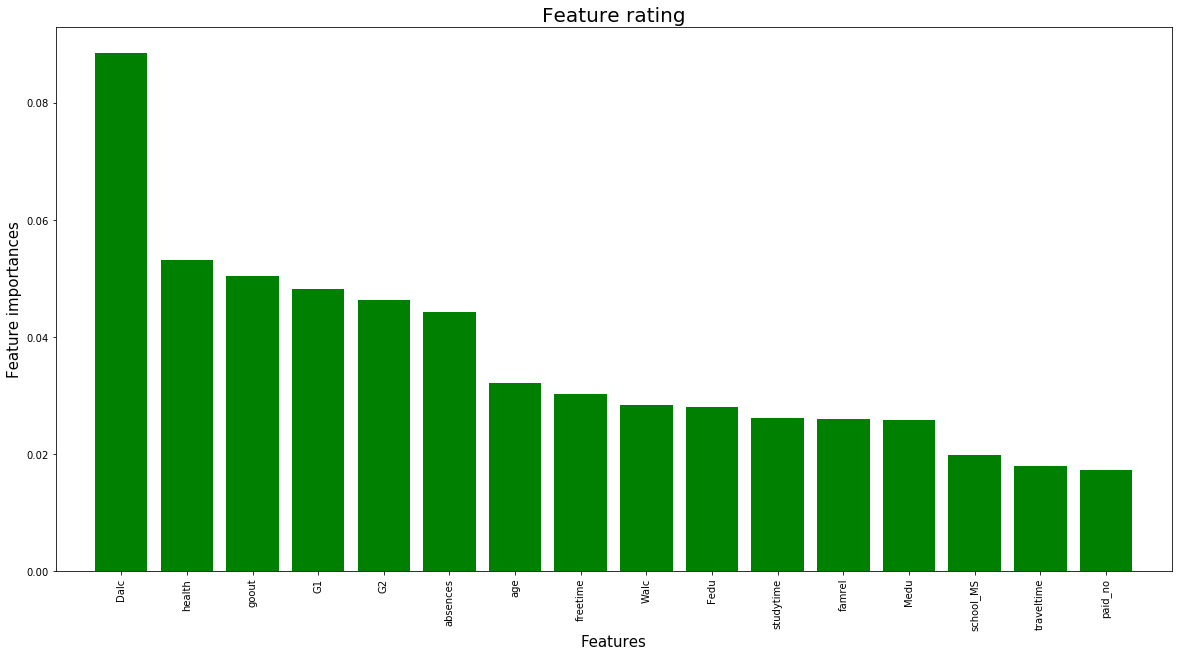

In [45]:
importances = rfc.fit(X_train,y_train).feature_importances_
importance_values = sorted(importances,reverse=True)
importance_columns = whole_data.columns[importances.argsort()[::-1]]

plt.figure(figsize=(20,10))
plt.title("Feature rating",fontsize=20)
plt.bar(range(16),importance_values[:16],color='g',align="center")
plt.xticks(range(16),importance_columns[:16],rotation=90)
plt.ylabel("Feature importance")
plt.xlim([-1,16])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Feature importances', fontsize=15)

In [46]:
print('Significantly correlated features: ' + ', '.join(good_features))

Significantly correlated features: studytime, age, G1, G2, Medu, Fedu, traveltime, failures, famrel, freetime, Dalc, school_GP, school_MS, sex_F, sex_M, schoolsup_no, schoolsup_yes, higher_no, higher_yes, Walc


Using the obtained knowledge we discussed with parents the importance of good family relationships and desirable restrictions on a workday  alcohol consumption which could lead to decrease in weekend alcohol consumption as well. Also, we found out that parent's lavel of education, amount of time spent on studying and amount of freetime is important too. Knowing all that we modeled all the changes that, in our opinion, should lead to a better result and tested new data with our model.

Weekdays excessive alcohol consumption percentage before optimization: 40.2532
Weekdays excessive alcohol consumption percentage after optimization: 7.0886
Cohen-Kappa score: 0.2270


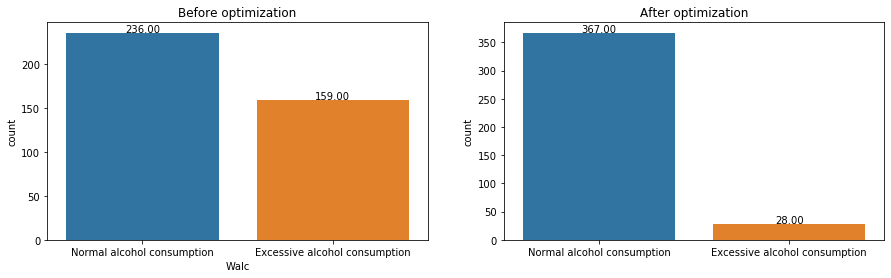

In [47]:
updated_data = whole_data.copy(deep=True).drop('Walc',1)
updated_data['freetime'] = updated_data['freetime'].apply(lambda x: math.ceil(x * .2)).apply(lambda x: x if x <= 5 else 5)
updated_data['famrel'] = updated_data['famrel'].apply(lambda x: math.ceil(x * 2)).apply(lambda x: x if x <= 5 else 5)
updated_data['Dalc'] = updated_data['Dalc'].apply(lambda x: math.ceil(x * .1)).apply(lambda x: x if x <= 5 else 5)
updated_data['Medu'] = updated_data['Medu'] + 1
updated_data['studytime'] = updated_data['studytime'] + 1
forest_walc = RandomForestClassifier(random_state = 42).fit(whole_data.drop('Walc',1)[good_predictors],whole_data.Walc)

print('Weekdays excessive alcohol consumption percentage before optimization: %.4f' % (sum(data.Walc > 2) / data.shape[0]  * 100))
print('Weekdays excessive alcohol consumption percentage after optimization: %.4f' % (sum(forest_walc.predict(updated_data[good_predictors]) > 2) / data.shape[0] * 100))
# print('Cohen-Kappa score: %.4f' % (cohen_kappa_score(data.G3,lr.predict(updated_data))))
print('Cohen-Kappa score: %.4f' % (cohen_kappa_score(data.Walc,(forest_walc.predict(updated_data[good_predictors])).astype('int32'))))

fig,ax = plt.subplots(1,2,figsize=(15,4))
sns.countplot((data.Walc > 2).replace({True:'Excessive alcohol consumption',\
                                       False:'Normal alcohol consumption'}),ax=ax[0])
ax[0].set_title('Before optimization')
sns.countplot(['Excessive alcohol consumption' if x == True else 'Normal alcohol consumption'\
               for x in (forest_walc.predict(updated_data[good_predictors]) > 2)],ax = ax[1])
ax[1].set_title('After optimization')
for ax_ in ax.flatten():
    show_values_on_bars(ax_)

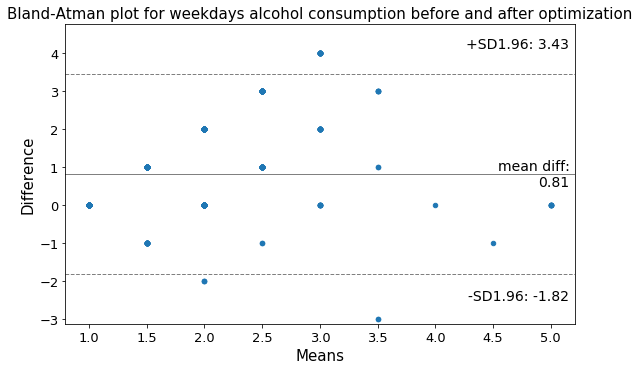

In [48]:
f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(data.Walc, forest_walc.predict(updated_data[good_predictors]),ax=ax)
ax.set_title('Bland-Atman plot for weekdays alcohol consumption before and after optimization',fontsize=15)
plt.show()

Again, the Cohen-Cappa score and the Bland-Atman plot confirm that the changes in the process are real.


In [49]:
print('DPMO before optimization: %.4f, Sigma ~ 1.7' % (sum(data.Walc > 2) / len(data.Walc) * 10**6))
print('DPMO after optimization: %.4f, Sigma ~ 3' % (sum(forest_walc.predict(updated_data[good_predictors]) > 2) / len(data.Walc) * 10**6))

DPMO before optimization: 402531.6456, Sigma ~ 1.7
DPMO after optimization: 70886.0759, Sigma ~ 3


# Conclusion and discussion

In both cases we were able to improve the sigma value, so we can assume that optimization was succesfull. In the second case it was much more successfull and the reason for that might be that human behaviour is a very complicated process so it is much more easy to restrict students from doing something than to make them a better learners. Using statistical methods and visualization, we showed that in both cases the situation was different before and after optimization.

As far as we know, this is the first attempt to apply the Six Sigma to the human behaviour prediction and improvement. From the theoretical stand and modeling it seems, that this methodology could lead to significant improvements in this area, but further study is recimmended.

Main suggestion for the further optimization is to gather much more data, since it is hard to perform a good statistical analysis on a dataset that includes less then 400 entries. All the assumtptions of this research have to be checked again on the larger dataset with the use of the methods described above. 

# Literature

[1] P. P. Bržan and D. Dinevski, “Medicinske raziskave in biostatistika s praktičnimi primeri v programu spss,” pp. 110–138.

[2] Wasserstein, Ronald L.; Lazar, Nicole A. (7 March 2016). "The ASA's Statement on p-Values: Context, Process, and Purpose". The American Statistician. 70 (2): 129–133

[3] Lehmann, Erich L., Romano, Joseph P.; "Testing Statistical Hypotheses"

[4] Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems, vol 1 p. 163

[5] David W. Hosmer Jr., Stanley Lemeshow, Rodney X. Sturdivant; "Applied Logistic Regression, 3rd Edition"

[6] Machine Learning With Random Forests And Decision Trees: A Visual Guide For Beginners, 2019

[7] Sasaki, Y. (2007). "The truth of the F-measure"

[8] McHugh, Mary L. (2012). "Interrater reliability: The kappa statistic". Biochemia Medica. 22 (3): 276–282

[9] Altman DG, Bland JM (1983). "Measurement in medicine: the analysis of method comparison studies". The Statistician. 32 (3): 307–317

[10] George, Michael; Rowlands, David; Price, Mark; Maxey, John. Using DMAIC to improve speed, quality, and cost // The Lean Six Sigma Pocket Toolbook: A Quick Reference Guide to Nearly 100 Tools for Improving Process Quality, Speed, and Complexity. — N. Y.: McGraw-Hill, 2005. — P. 1-26. — 282 p